In [1]:
import jax
import jax.numpy as jnp
from tqdm import tqdm
import netket as nk
import optax
import netket.jax as nkjax
# import netket_pro as nkp
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate

from grad_sample.tasks.fullsum_train import Trainer
from grad_sample.utils.is_distrib import *
from grad_sample.utils.plotting_setup import *
from grad_sample.is_hpsi.expect import *
from grad_sample.is_hpsi.qgt import QGTJacobianDenseImportanceSampling
from grad_sample.is_hpsi.operator import IS_Operator
from netket.jax._jacobian.logic import _multiply_by_pdf
from grad_sample.utils.tree_op import dagger_pytree, vjp_pytree, mul_pytree, shape_tree, pytree_mean
from grad_sample.tasks.fullsum_snr_is import _compute_S_F, _compute_S_F_var

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if GlobalHydra().is_initialized():
    GlobalHydra().clear()
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="base")
    OmegaConf.set_struct(cfg, True)
    print(cfg)
    print(cfg.task)
    # cfg = OmegaConf.to_yaml(cfg)
    # take any task from cfg and run it
# analysis = FullSumPruning(cfg)
trainer = Trainer(cfg)

{'device': '5', 'is_mode': None, 'solver_fn': {'_target_': 'netket.optimizer.solver.cholesky'}, 'lr': 0.002, 'diag_shift': 'schedule', 'n_iter': 6000, 'sample_size': 10, 'chunk_size_jac': 1024, 'chunk_size_vmap': 100, 'save_every': 10, 'run_index': 0, 'base_path': '/scratch/.amisery/grad_sample_fullsum/', 'model': {'_target_': 'grad_sample.models.ising.TFI', 'L': 4, 'h': 1.0}, 'ansatz': {'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}, 'task': {'_target_': 'grad_sample.tasks.fullsum_snr_is.FullSumIS'}}
{'_target_': 'grad_sample.tasks.fullsum_snr_is.FullSumIS'}
[CudaDevice(id=0)]
{'_target_': 'netket.models.RBM', 'alpha': 3, 'param_dtype': 'complex'}
MC state loaded, num samples 1024
/scratch/.amisery/grad_sample_fullsum//ising_1.0/L4/RBM/alpha3/MC_10/0.002_schedule/run_0
The ground state energy is: -34.010597550846256


In [4]:
trainer.sample_size

10

In [5]:
alpha = 0.5
num_resample = 1000
chunk_size_resample = 50
Nsample = 2**trainer.sample_size
is_op = IS_Operator(operator = trainer.model.H_jax, is_mode=alpha)
log_q, log_q_vars = is_op.get_log_importance(trainer.vstate)
# vstate_fs = nk.vqs.FullSumState(hilbert=trainer.model.hi, model=trainer.ansatz, chunk_size= None)
# e_fs, fs_grad = vstate_fs.expect_and_grad(trainer.model.H_jax)

# pdf = vstate_fs.probability_distribution()
# jac_fs =  nkjax.jacobian(
#         vstate_fs._apply_fun,
#         vstate_fs.parameters,
#         vstate_fs.hilbert.all_states(), #in MC state, this is vstate.samples
#         vstate_fs.model_state,
#         pdf=pdf,
#         mode=trainer.mode,
#         dense=False,
#         center=False,
#         chunk_size=10,
#         _sqrt_rescale=False, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
#     )

# mean_jac_fs = tree_map(lambda x: jnp.sum(x*jnp.broadcast_to(pdf, x.T.shape).T,axis=0), jac_fs)
# print(shape_tree(mean_jac_fs))
compute_S_F = jax.jit(nkjax.vmap_chunked(lambda s : _compute_S_F(s, trainer.vstate._apply_fun, trainer.vstate.parameters, trainer.vstate.model_state, log_q, log_q_vars, trainer.chunk_size_jac//2, is_op, trainer.solver_fn, 1e-3), in_axes=0, chunk_size = chunk_size_resample))

In [6]:
# with jax.checking_leaks():
# samples = trainer.vstate.sample_distribution(
# log_q,
# variables=log_q_vars, n_samples = Nsample
# )
# samples = trainer.vstate.samples

# test compared to netket when alpha is 2
# O_exp, O_grad, ng  = _compute_S_F(samples, trainer.vstate._apply_fun, trainer.vstate.parameters, trainer.vstate.model_state, log_q, log_q_vars, trainer.chunk_size_jac//2, is_op, trainer.solver_fn, trainer.diag_shift(0))
# exp_netket, grad_netket = trainer.vstate.expect_and_grad(trainer.model.H_jax)
# jax.tree_util.tree_map(lambda x,y: x/y, O_grad, grad_netket)

# batch_sample = samples.reshape((num_resample, 1, Nsample, -1))
# e, grad_e , ng = compute_S_F(batch_sample)

In [7]:
samples = trainer.vstate.sample_distribution(
log_q,
variables=log_q_vars, n_samples = Nsample
)
O_exp, O_force, ng = _compute_S_F(samples, trainer.vstate._apply_fun, trainer.vstate.parameters, trainer.vstate.model_state, log_q, log_q_vars, trainer.chunk_size_jac//4, is_op, trainer.solver_fn, trainer.diag_shift(0))

In [8]:
# estimate gradient variance with resampling
samples = trainer.vstate.sample_distribution(
log_q,
variables=log_q_vars, n_samples = Nsample * num_resample
)
batch_sample = samples.reshape((num_resample, 1, Nsample, -1))
e, force_e , ng= compute_S_F(batch_sample)

In [9]:
var_resampling = tree_map(lambda g : jnp.var(g, axis=0), force_e)

In [10]:
# test compared to theoretical variance formula
@partial(jax.jit, static_argnames=("log_psi", "log_q", "chunk_size"))
def expect_grad_var(
    force, log_psi, parameters, model_state, log_q, q_vars, operator, sigma_psi_sq, sigma_alpha, chunk_size
):
    O = operator.operator
    parameters = {"params": parameters}

    sigma_psi_sq = sigma_psi_sq.reshape(sigma_psi_sq.shape[0]*sigma_psi_sq.shape[1], -1)
    sigma_alpha = sigma_alpha.reshape(sigma_alpha.shape[0]*sigma_alpha.shape[1], -1)

    n_samples = sigma_psi_sq.shape[0]

    # Compute standard Expectation value
    log_psi_sigma_psi_sq = nkjax.apply_chunked(lambda x: log_psi(parameters, x), chunk_size=chunk_size)(sigma_psi_sq)
    log_q_sigma_psi_sq = nkjax.apply_chunked(lambda x: log_q(q_vars, x), chunk_size=chunk_size)(sigma_psi_sq)

    log_psi_sigma_alpha = nkjax.apply_chunked(lambda x: log_psi(parameters, x), chunk_size=chunk_size)(sigma_alpha)
    log_q_sigma_alpha = nkjax.apply_chunked(lambda x: log_q(q_vars, x), chunk_size=chunk_size)(sigma_alpha)

    # estimate local forces for new sample
    eta, etap_mels = O.get_conn_padded(sigma_psi_sq)
    _eta = eta.reshape(-1, eta.shape[-1])
    log_psi_eta = nkjax.apply_chunked(lambda x: log_psi(parameters, x), chunk_size=chunk_size)(
        _eta
    )

    # del _eta_Hpsi
    log_psi_eta = log_psi_eta.reshape(eta.shape[:-1])
    w_is_sigma_psi_sq = jnp.abs(jnp.exp(log_psi_sigma_psi_sq - log_q_sigma_psi_sq))**2

    w_is_sigma_alpha = jnp.abs(jnp.exp(log_psi_sigma_alpha - log_q_sigma_alpha))**2
    Z_ratio = 1/nkstats.mean(w_is_sigma_alpha)

    op_loc = jnp.sum(etap_mels * jnp.exp(log_psi_eta- jnp.expand_dims(log_psi_sigma_psi_sq, axis=-1)), axis=-1)
    O_mean = nkstats.mean(op_loc)
    op_loc_c = op_loc - O_mean
    
    jac_mode  = operator.mode
    # compute centered jacobian with psi squared samples
    jacobian_pytree_c = nkjax.jacobian(
        lambda w, sigma: log_psi(w, sigma),
        parameters["params"],
        sigma_psi_sq,
        model_state,
        mode = jac_mode,
        chunk_size=chunk_size,
        dense=False,
        center=True
    )
    force_pytree_unrolled = mul_pytree(dagger_pytree(jacobian_pytree_c), op_loc_c)
    # loc_var = tree_map(lambda x,y: jnp.mean(jnp.broadcast_to(w_is_sigma_psi_sq * Z_ratio, y.shape) * jnp.abs(jnp.expand_dims(x.T,-1)-y)**2, axis=-1)/jnp.abs(x.T)**2, force, force_pytree_unrolled)
    loc_var = tree_map(lambda x,y: jnp.mean(jnp.broadcast_to(w_is_sigma_psi_sq * Z_ratio/ log_psi_sigma_alpha.size, y.shape) * jnp.abs(jnp.expand_dims(x.T,-1)-y)**2, axis=-1), force, force_pytree_unrolled)
    
    log_modulus_sigma = nkjax.apply_chunked(lambda x: jnp.log(jnp.abs(jnp.exp(log_psi(parameters, x)))), chunk_size=chunk_size)(sigma_psi_sq)
    
    log_modulus_sigma_alpha = nkjax.apply_chunked(lambda x: jnp.log(jnp.abs(jnp.exp(log_psi(parameters, x)))), chunk_size=chunk_size)(sigma_alpha)
    log_modulus_sigma -= jnp.mean(log_modulus_sigma_alpha)
    grad_var = tree_map(lambda x,y: -jnp.mean(jnp.broadcast_to(w_is_sigma_psi_sq * Z_ratio * log_modulus_sigma/log_psi_sigma_alpha.size, y.shape) * jnp.abs(jnp.expand_dims(x.T,-1)-y)**2, axis=-1)/jnp.abs(x.T)**2, force, force_pytree_unrolled)

    return loc_var, grad_var

In [11]:
from functools import partial
# test compared to theoretical variance formula
# @partial(jax.jit, static_argnames=("log_psi", "log_q", "chunk_size"))
def expect_grad_var_is(
    force, log_psi, parameters, model_state, log_q, q_vars, operator, sigma_alpha, chunk_size
):
    O = operator.operator
    parameters = {"params": parameters}

    sigma_alpha = sigma_alpha.reshape(sigma_alpha.shape[0]*sigma_alpha.shape[1], -1)

    # Compute standard Expectation value
    log_psi_sigma_alpha = nkjax.apply_chunked(lambda x: log_psi(parameters, x), chunk_size=chunk_size)(sigma_alpha)
    log_q_sigma_alpha = nkjax.apply_chunked(lambda x: log_q(q_vars, x), chunk_size=chunk_size)(sigma_alpha)

    # estimate local forces for new sample
    eta, etap_mels = O.get_conn_padded(sigma_alpha)
    _eta = eta.reshape(-1, eta.shape[-1])
    log_psi_eta = nkjax.apply_chunked(lambda x: log_psi(parameters, x), chunk_size=chunk_size)(
        _eta
    )

    # del _eta_Hpsi
    log_psi_eta = log_psi_eta.reshape(eta.shape[:-1])

    w_is_sigma_alpha = jnp.abs(jnp.exp(log_psi_sigma_alpha - log_q_sigma_alpha))**2
    Z_ratio = 1/nkstats.mean(w_is_sigma_alpha)

    op_loc = jnp.sum(etap_mels * jnp.exp(log_psi_eta- jnp.expand_dims(log_psi_sigma_alpha, axis=-1)), axis=-1)
    O_mean = nkstats.mean(Z_ratio* w_is_sigma_alpha * op_loc)
    op_loc_c = op_loc - O_mean
    # plt.hist(Z_ratio*w_is_sigma_alpha*op_loc_c, bins=50)
    jac_mode  = operator.mode
    # compute centered jacobian with psi squared samples
    jacobian_pytree = nkjax.jacobian(
        lambda w, sigma: log_psi(w, sigma),
        parameters["params"],
        sigma_alpha,
        model_state,
        mode = jac_mode,
        chunk_size=chunk_size,
        dense=False,
        center=False
    )
    jacobians_avg = jax.tree_util.tree_map(
        partial(jnp.mean, axis=0, keepdims=True), _multiply_by_pdf(jacobian_pytree, w_is_sigma_alpha)
    )
    jacobians = jax.tree_util.tree_map(
        lambda x, y: x - Z_ratio*y, jacobian_pytree, jacobians_avg
    )
    jac_dense_t = jnp.concatenate([jnp.reshape(x, (-1,x.shape[0])) for x in jax.tree.flatten(jacobians)[0]])
    # plt.hist(jac_dense_t[0,:], bins=50)
    # plt.hist(w_is_sigma_alpha*jacobians)
    force_pytree_unrolled = mul_pytree(dagger_pytree(jacobians), op_loc_c)
    # loc_var = tree_map(lambda x,y: jnp.mean(jnp.broadcast_to((w_is_sigma_alpha * Z_ratio)**2, y.shape) * jnp.abs(jnp.expand_dims(x.T,-1)-y)**2, axis=-1)/jnp.abs(x.T)**2, force, force_pytree_unrolled)
    loc_var = tree_map(lambda x,y: jnp.mean(jnp.broadcast_to((w_is_sigma_alpha * Z_ratio)**2/log_psi_sigma_alpha.size, y.shape) * jnp.abs(jnp.expand_dims(x.T,-1)-y)**2, axis=-1), force, force_pytree_unrolled)
    # loc_var = tree_map(lambda x,y: jnp.mean(jnp.broadcast_to((w_is_sigma_alpha * Z_ratio)**2, y.shape) * jnp.abs(jnp.expand_dims(x.T,-1)-y)**2, axis=-1), force_pytree_unrolled)
    # loc_var = tree_map(lambda y: jnp.mean(jnp.broadcast_to((w_is_sigma_alpha * Z_ratio)**2 * Z_ratio**2 / log_psi_sigma_alpha.size, y.shape) * jnp.abs(1-y)**2, axis=-1), force_pytree_unrolled)
    
    log_modulus_sigma = nkjax.apply_chunked(lambda x: jnp.log(jnp.abs(jnp.exp(log_psi(parameters, x)))), chunk_size=chunk_size)(sigma_alpha)
    
    log_modulus_sigma_alpha = nkjax.apply_chunked(lambda x: jnp.log(jnp.abs(jnp.exp(log_psi(parameters, x)))), chunk_size=chunk_size)(sigma_alpha)
    log_modulus_sigma -= jnp.mean(log_modulus_sigma_alpha)
    # returns gradient of 1/snr^2 = var/|mu|^2
    grad_var = tree_map(lambda x,y: -jnp.mean(jnp.broadcast_to((w_is_sigma_alpha * Z_ratio)**2 * log_modulus_sigma/log_psi_sigma_alpha.size, y.shape) * jnp.abs(jnp.expand_dims(x.T,-1)-y)**2, axis=-1)/jnp.abs(x.T)**2, force, force_pytree_unrolled)

    # returns gradient of -snr = -|mu|/sqrt(var)
    # grad_snr = tree_map(lambda mu,var,grad : jnp.abs(mu)/var**(3/2)* grad/2)
    return loc_var, grad_var
    # return loc_var, grad_snr

In [12]:
samples_alpha = trainer.vstate.sample_distribution(
log_q,
variables=log_q_vars, n_samples = Nsample
)
var_exact, grad_var = expect_grad_var(O_force, trainer.vstate._apply_fun, trainer.vstate.parameters, trainer.vstate.model_state, log_q, log_q_vars, is_op, trainer.vstate.samples, samples_alpha, trainer.chunk_size_jac)

In [13]:
samples_alpha = trainer.vstate.sample_distribution(
log_q,
variables=log_q_vars, n_samples = Nsample
)
var_exact_is, grad_var_is = expect_grad_var_is(O_force, 
                                trainer.vstate._apply_fun, 
                                trainer.vstate.parameters, 
                                trainer.vstate.model_state, 
                                log_q, log_q_vars, 
                                is_op, samples_alpha, trainer.chunk_size_jac)

In [14]:
pytree_mean(var_exact_is)/pytree_mean(var_resampling)

Array(1.01417296, dtype=float64)

In [15]:
tree_map(lambda x,y: jnp.abs(x/y), var_exact_is, var_exact)

{'Dense': {'bias': Array([0.97910273, 1.0463876 , 1.06114459, 1.14947825, 1.00049804,
         0.972643  , 1.21853928, 1.09615633, 1.07889409, 0.92097097,
         1.00706161, 1.06384749, 0.86461106, 1.14822194, 0.96845661,
         0.91707366, 0.97857218, 1.15939663, 0.89220543, 0.89085867,
         0.95332635, 1.07408409, 1.02279348, 1.03692262, 1.00323365,
         1.0193894 , 1.12843778, 0.96823419, 0.98300601, 0.92209527,
         1.1987466 , 0.90574496, 1.01506606, 1.10205605, 1.00925412,
         0.96898396, 0.99514555, 1.06790626, 1.04767212, 1.00443712,
         1.0292536 , 0.96227228, 1.0815846 , 1.17226306, 0.9908864 ,
         1.08198139, 1.12687596, 1.03139261], dtype=float64),
  'kernel': Array([[1.0689335 , 1.0500902 , 1.10051983, 1.05233277, 1.05084401,
          1.07129424, 1.05830218, 1.04745175, 1.10240135, 1.09856249,
          1.06041717, 1.07745178, 1.08892026, 1.03753841, 1.08925766,
          1.06143461],
         [1.08491827, 1.11653533, 1.11282165, 1.11488738,

In [16]:
tree_map(lambda x,y: jnp.abs(x/y.T), var_exact_is, var_resampling)

{'Dense': {'bias': Array([0.90075979, 0.98639991, 1.04265574, 1.06130411, 0.95139042,
         0.94763005, 1.13128028, 1.08585708, 1.00607961, 0.94930484,
         1.00156801, 1.01027208, 0.8325339 , 1.06693622, 0.90587035,
         0.97630973, 1.00356419, 1.05306335, 0.96341984, 0.87116118,
         0.93895701, 1.1308463 , 1.03786151, 0.99698458, 1.11286451,
         1.01351636, 1.02146292, 0.84493417, 1.05492657, 1.08222241,
         1.09982928, 0.94457134, 0.96914015, 1.11491061, 1.07984378,
         0.98025163, 1.04415539, 0.98527085, 1.08895325, 1.00496745,
         0.91850491, 0.93585255, 0.97730606, 1.07095972, 0.96768715,
         1.13640639, 1.03633186, 1.05513008], dtype=float64),
  'kernel': Array([[0.95837948, 0.94363169, 1.0471324 , 1.05809021, 0.99335183,
          0.97918735, 0.99544799, 0.92727593, 0.93418126, 0.99903515,
          0.95735565, 0.96309129, 0.96705504, 0.95853039, 0.92119394,
          0.95634884],
         [0.98309131, 1.00443545, 0.9910912 , 1.04206187,

In [17]:
# try optimizing alpha starting at alpha =2
# lr=2400
# alpha_s = 2.0
# n_steps = 20
# al = []
# varl = []
# gradvarl = []
# for n in tqdm(range(n_steps)):
#     is_ops = IS_Operator(operator = trainer.model.H_jax, is_mode=alpha_s)
#     log_qs, log_qs_vars = is_ops.get_log_importance(trainer.vstate)
#     samples_alphas = trainer.vstate.sample_distribution(
#                                             log_qs,
#                                             variables=log_qs_vars, n_samples = Nsample
#                                             )

#     O_exp, O_grad, ng  = _compute_S_F(samples_alphas, trainer.vstate._apply_fun, trainer.vstate.parameters, trainer.vstate.model_state, log_q, log_q_vars, trainer.chunk_size_jac//2, is_op, trainer.solver_fn, trainer.diag_shift(0))

#     var_exact, grad_var = expect_grad_var(O_grad, trainer.vstate._apply_fun, trainer.vstate.parameters, trainer.vstate.model_state, log_qs, log_qs_vars, is_ops, trainer.vstate.samples, samples_alphas, trainer.chunk_size_jac)
#     varl.append(pytree_mean(var_exact))
#     gradvarl.append(pytree_mean(grad_var))
#     al.append(alpha_s)
#     alpha_s -= lr*pytree_mean(grad_var)

In [18]:
import copy

def apply_gradient(optimizer_fun, optimizer_state, dp, params):
    updates, new_optimizer_state = optimizer_fun(dp, optimizer_state, params)

    new_params = optax.apply_updates(params, updates)

    return new_optimizer_state, new_params
    return True

def rel_err_fs(vstate, fs_state, is_op, e_gs):
    fs_state.variables = copy.deepcopy(vstate.variables)
    # e = fs_state.expect(driver._ham.operator).mean.real
    e = fs_state.expect(is_op.operator).mean.real
    return jnp.abs(e-e_gs)/jnp.abs(e_gs)

In [19]:
import numpy as np
from tqdm import tqdm
from netket.vqs import FullSumState
# Initialize variables
alpha_s = 2.0
n_iter = 2000
warmup = 50
update_stride = 2
lr = 0.005
epsilon = 1e-8  # Small constant to prevent division by zero
stride_rel_err = 20
# Define the optimizer
alpha_opt = optax.adam(learning_rate=0.1, eps=1e-8)  # Adagrad optimizer
alpha_opt_state = alpha_opt.init(alpha_s) 
fs_state_rel_err = FullSumState(hilbert = trainer.vstate.hilbert, model = trainer.vstate.model, chunk_size=None, seed=0)
       
al = []
itvar = []
varl = []
gradvarl = []
itrel = []
rel_errl = []
is_ops = IS_Operator(operator=trainer.model.H_jax, is_mode=alpha_s)
trainer.vstate.init_parameters(seed=0)
opt_state = trainer.opt.init(trainer.vstate.parameters)

with tqdm(
                total=n_iter,
                disable=False,
                dynamic_ncols=True,
            ) as pbar:
    # Optimization loop
    for n in tqdm(range(n_iter)):
        # Create IS operator and get log importance weights
        log_qs, log_qs_vars = is_ops.get_log_importance(trainer.vstate)
        
        # Sample from the distribution
        samples_alphas = trainer.vstate.sample_distribution(
            log_qs,
            variables=log_qs_vars,
            n_samples=trainer.Nsample
        )
        if n%update_stride ==1 and n > warmup:
            O_exp, O_grad, ng, var, grad_var = _compute_S_F_var(
            samples_alphas,
            trainer.vstate._apply_fun,
            trainer.vstate.parameters,
            trainer.vstate.model_state,
            log_qs,
            log_qs_vars,
            trainer.chunk_size_jac // 2,
            is_ops,
            trainer.solver_fn,
            1e-4,
            )  
            # Compute mean of variance and gradient variance
            varl.append(pytree_mean(var))
            grad_var_mean = pytree_mean(grad_var)
            gradvarl.append(grad_var_mean)
            al.append(alpha_s)

            itvar.append(n)
            # optax update
            # updates, alpha_opt_state = alpha_opt.update(grad_var_mean, alpha_opt_state)
            # alpha_s_new = optax.apply_updates(alpha_s, updates)  # Update alpha_s

            # heuristic update
            if grad_var_mean > 0:
                alpha_s_new = alpha_s - lr
            else:
                alpha_s_new = alpha_s + lr
                
            if alpha_s_new > 0:
                alpha_s = alpha_s_new
                is_ops._is_mode = alpha_s 
                # is_ops = IS_Operator(operator=trainer.model.H_jax, is_mode=alpha_s)

        else:
            O_exp, O_grad, ng = _compute_S_F(
            samples_alphas,
            trainer.vstate._apply_fun,
            trainer.vstate.parameters,
            trainer.vstate.model_state,
            log_qs,
            log_qs_vars,
            trainer.chunk_size_jac // 2,
            is_ops,
            trainer.solver_fn,
            1e-4,
            )  

        opt_state, trainer.vstate.parameters = apply_gradient(trainer.opt.update, opt_state, ng[0], trainer.vstate.parameters)
        
        if n%stride_rel_err == 0:
            rel_errl.append(rel_err_fs(trainer.vstate, fs_state_rel_err, is_ops, trainer.E_gs))
            itrel.append(n)
        pbar.set_postfix_str(
                    "E = %s ; alpha = %.2f"%(O_exp, alpha_s)
                    )
        pbar.update(1)

 11%|█         | 223/2000 [02:41<21:26,  1.38it/s, E = -34.01139781536854 ; alpha = 1.61]


KeyboardInterrupt: 

Text(0.5, 0.98, 'Automatic tuning of $\\alpha$, update every 2, warmup of 50 steps, heuristic step 0.01')

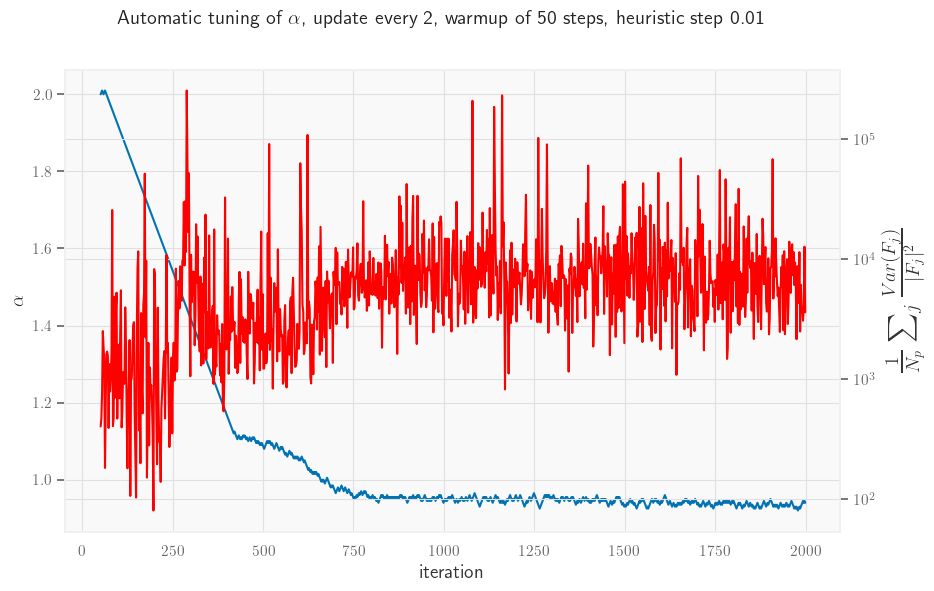

In [20]:
fig, axes = plt.subplots()
axes.plot(itvar, al)
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(varl), color='red')
axes1.set_yscale('symlog')

axes.set_xlabel('iteration')
axes.set_ylabel(r'$\alpha$')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)

fig.suptitle(r'Automatic tuning of $\alpha$, update every %d, warmup of %d steps, heuristic step %.2f'%(update_stride, warmup, lr))

Text(0.5, 0.98, 'Relative error and gradient variance, no tuning')

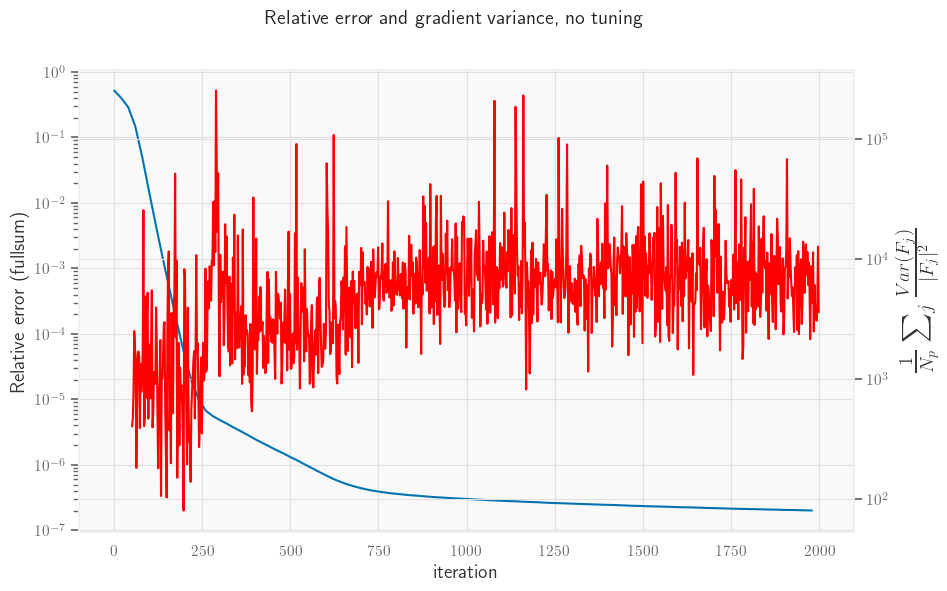

In [21]:
fig, axes = plt.subplots()
axes.plot(itrel, rel_errl)
axes.set_yscale('log')
axes1 = axes.twinx()
axes1.plot(itvar, jnp.array(varl), color='red')
axes1.set_yscale('symlog')

axes.set_xlabel('iteration')
axes.set_ylabel('Relative error (fullsum)')
axes1.set_ylabel(r'$\frac{1}{N_p}\sum_j\frac{Var(F_j)}{|F_j|^2}$', fontsize=20)
fig.suptitle('Relative error and gradient variance, no tuning')

In [22]:
import optax
from tqdm import tqdm

# Initialize variables
alpha_s = jnp.array(2.0)  # alpha_s as a JAX array for compatibility
n_steps = 20

# Define the optimizer
optimizer = optax.adagrad(learning_rate=1.0, eps=1e-8)  # Adagrad optimizer
opt_state = optimizer.init(alpha_s)  # Initialize optimizer state

al = []
varl = []
gradvarl = []

# Optimization loop
for n in tqdm(range(n_steps)):
    # Create IS operator and get log importance weights
    is_ops = IS_Operator(operator=trainer.model.H_jax, is_mode=alpha_s)
    log_qs, log_qs_vars = is_ops.get_log_importance(trainer.vstate)
    
    # Sample from the distribution
    samples_alphas = trainer.vstate.sample_distribution(
        log_qs,
        variables=log_qs_vars,
        n_samples=Nsample
    )
    
    # Compute the observable and its gradients
    O_exp, O_grad, ng = _compute_S_F(
        samples_alphas,
        trainer.vstate._apply_fun,
        trainer.vstate.parameters,
        trainer.vstate.model_state,
        log_qs,
        log_qs_vars,
        trainer.chunk_size_jac // 2,
        is_ops,
        trainer.solver_fn,
        trainer.diag_shift(0)
    )
    
    # Compute variance and gradient variance
    var_exact, grad_var = expect_grad_var(
        O_grad,
        trainer.vstate._apply_fun,
        trainer.vstate.parameters,
        trainer.vstate.model_state,
        log_qs,
        log_qs_vars,
        is_ops,
        trainer.vstate.samples,
        samples_alphas,
        trainer.chunk_size_jac
    )
    
    # Compute mean of variance and gradient variance
    varl.append(pytree_mean(var_exact))
    grad_var_mean = pytree_mean(grad_var)
    gradvarl.append(grad_var_mean)
    al.append(alpha_s)
    
    # Compute the gradient update using Optax
    updates, opt_state = optimizer.update(grad_var_mean, opt_state)
    alpha_s = optax.apply_updates(alpha_s, updates)  # Update alpha_s

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


In [23]:
is_ops = IS_Operator(operator = trainer.model.H_jax, is_mode=alpha_s)

In [24]:
n = 2**9

In [25]:
mean_ratio = pytree_mean(var_exact) / pytree_mean(var_resampling)

In [26]:
print(mean_ratio)

3.818346205495429e-07


In [27]:
tree_map(lambda x,y: x/y.T/240, var_exact, var_resampling)

{'Dense': {'bias': Array([3.14224198e-08, 5.25805237e-09, 8.43683487e-09, 1.50048215e-07,
         7.02342153e-09, 1.55983367e-08, 4.92055972e-09, 6.28852088e-08,
         1.06244676e-08, 2.29424290e-08, 6.54559077e-09, 1.85270770e-08,
         8.03418655e-09, 1.09177523e-08, 3.40833898e-08, 1.26851337e-07,
         6.65093400e-09, 2.06922579e-08, 1.40934159e-08, 4.40233915e-08,
         3.21193823e-08, 1.41611509e-07, 1.42041677e-09, 2.31801627e-07,
         4.26242008e-08, 1.90646200e-07, 9.07253881e-09, 1.02577572e-08,
         2.99631665e-08, 6.00548980e-09, 2.54374923e-08, 4.75297438e-09,
         2.19904896e-09, 1.70198215e-09, 2.77669262e-09, 1.82011607e-08,
         7.48864456e-08, 2.97838856e-09, 3.66634268e-09, 2.84621351e-08,
         3.45840418e-08, 9.56746965e-09, 9.26461802e-09, 5.30788822e-09,
         9.35176018e-09, 8.00976853e-09, 4.89022660e-08, 7.84823345e-09],      dtype=float64),
  'kernel': Array([[3.32414998e-08, 1.93813122e-08, 1.75009221e-08, 1.39117527e-08,
 

In [28]:
is_op = IS_Operator(operator = trainer.model.H_jax)

TypeError: IS_Operator.__init__() missing 1 required positional argument: 'is_mode'

In [ ]:
# no is, calculations done with vstate
trainer.vstate.expect(trainer.model.H_jax)

In [ ]:
qgt1 =QGTJacobianDenseImportanceSampling(
    importance_operator=is_op, chunk_size=trainer.chunk_size_jac
)
sr_is = nk.optimizer.SR(qgt=qgt1, diag_shift=1e-4, solver=nk.optimizer.solver.cholesky, holomorphic=True)

print("ED:", nk.exact.lanczos_ed(is_op.operator))

log = nk.logging.RuntimeLog()

In [ ]:
opt = nk.optimizer.Sgd(learning_rate=0.005)
op = trainer.model.H
sr = nk.optimizer.SR(solver=nk.optimizer.solver.cholesky, diag_shift=1e-4, holomorphic= True)
gs_is = nk.VMC(is_op, opt, variational_state=trainer.vstate, preconditioner=sr_is)
gs_is.run(n_iter=2000)
# trainer.gs.run(n_iter=100)

In [ ]:
gs_is.state.expect(is_op)

In [ ]:
exp, force_psi = trainer.vstate.expect_and_forces(trainer.model.H_jax);

In [ ]:
exp, force_hpsi =  gs_is.state.expect_and_forces(is_op)

In [ ]:
vstate_fs = nk.vqs.FullSumState(hilbert=trainer.model.hi, model=trainer.ansatz, chunk_size=trainer.chunk_size, seed=0)

In [ ]:
fs_e, force_fs = vstate_fs.expect_and_forces(trainer.model.H_jax)

In [ ]:
fs_e

In [ ]:
jax.tree_util.tree_map(lambda x,y: jnp.abs(x/y), force_fs, force_psi)

In [ ]:
jax.tree_util.tree_map(lambda x,y: jnp.abs(x/y), force_fs, force_hpsi)